## Assignment 4 : USA Space Shuttle Challenger 

Read https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster

Our task is to predict the number of O-rings that experience thermal distress on a flight at 31 degrees F given data on the previous 23 shuttle flights

Download the data: **o-ring-erosion-or-blowby.data** from https://archive.ics.uci.edu/ml/datasets/Challenger+USA+Space+Shuttle+O-Ring


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy, scipy.stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, xlabel, ylabel, savefig
% matplotlib inline

/Users/kimchaewon/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


 Number of Attributes: 
     1. Number of O-rings at risk on a given flight
     2. Number experiencing thermal distress
     3. Launch temperature (degrees F)
     4. Leak-check pressure (psi)
     5. Temporal order of flight

#### Data Loading

In [2]:
#Check the original data
!cat o-ring-erosion-or-blowby.data.txt

6 0 66  50  1
6 1 70  50  2
6 0 69  50  3
6 0 68  50  4
6 0 67  50  5
6 0 72  50  6
6 0 73 100  7
6 0 70 100  8
6 1 57 200  9
6 1 63 200 10
6 1 70 200 11
6 0 78 200 12
6 0 67 200 13
6 2 53 200 14
6 0 67 200 15
6 0 75 200 16
6 0 70 200 17
6 0 81 200 18
6 0 76 200 19
6 0 79 200 20
6 2 75 200 21
6 0 76 200 22
6 1 58 200 23


In [22]:
#Load the file into pandas DataFrame
data=pd.read_csv('o-ring-erosion-or-blowby.data.txt', delimiter="\s+", header = None, 
                names = ['Number of O-rings','Distress','Temperature', 'Pressure','Flight Order'])
#Number of O-rings at risk on a given flight is equally 6 so I decided to drop that column

#Added a column 'dict_pct' to include the probability of one o-ring's
# erossion/blowby at certain condition.
data['dist_pct'] = data['Distress'] / data['Number of O-rings'] * 100
df=data.drop('Number of O-rings', axis = 1)
df.set_index('Flight Order')

,Distress,Temperature,Pressure,dist_pct
Flight Order,,,,
1,0,66,50,0.000000
2,1,70,50,16.666667
3,0,69,50,0.000000
4,0,68,50,0.000000
5,0,67,50,0.000000
6,0,72,50,0.000000
7,0,73,100,0.000000
8,0,70,100,0.000000
9,1,57,200,16.666667


In [35]:
#Slicing data: when number of O-rings experiencing thermal distress is 1 OR 2
distress = df.loc[(df.Distress == 1) | (df.Distress ==2)]
distress
#Use 'groupby' to make it easier to understand the results
distress.groupby(['Temperature','Pressure','Distress'])['Distress'].count()

Temperature  Pressure  Distress
53           200       2           1
57           200       1           1
58           200       1           1
63           200       1           1
70           50        1           1
             200       1           1
75           200       2           1
Name: Distress, dtype: int64

In [36]:
#Slicing data: when no O-rings experience thermal distress 
no_distress=df.loc[(df.Distress==0)]
no_distress
#Use 'groupby' to make it easier to understand the results
no_distress.groupby(['Pressure','Temperature','Distress'])['Distress'].count()

Pressure  Temperature  Distress
50        66           0           1
          67           0           1
          68           0           1
          69           0           1
          72           0           1
100       70           0           1
          73           0           1
200       67           0           2
          70           0           1
          75           0           1
          76           0           2
          78           0           1
          79           0           1
          81           0           1
Name: Distress, dtype: int64

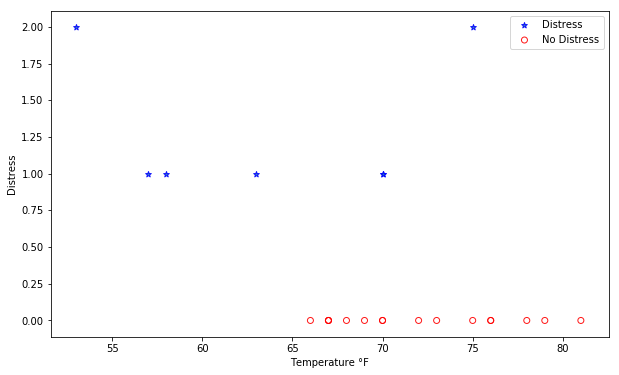

In [37]:
#Plotting the data into a scatter plot
plt.figure(figsize=(10,6))
plt.scatter(distress.Temperature,distress.Distress
        ,edgecolor='b', marker='*',label= 'Distress',
         alpha=0.9 )
plt.scatter(no_distress.Temperature,no_distress.Distress, 
            edgecolor='r',facecolor='None',label='No Distress',
            alpha=0.9)
plt.xlabel(u'Temperature \xb0F')
plt.ylabel('Distress')
plt.legend()

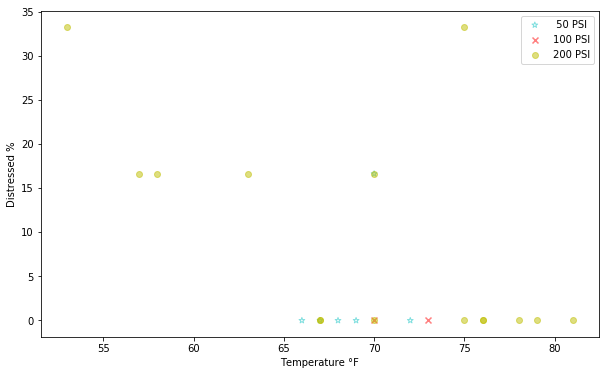

In [41]:
#Since the plot does not represent 'Pressure' values, we will do another plot that includes 'Pressure'
df50 = df[df.Pressure==50]
df100 = df[df.Pressure==100]
df200 = df[df.Pressure==200]

#Plot all samples in different pressure [50,100,200]
plt.figure(figsize=(10,6))
plt.scatter( df50.Temperature, df50.dist_pct, label=' 50 PSI',
          marker='*',
          edgecolor='c',
          facecolor='none',
          alpha=0.5 )
plt.scatter( df100.Temperature, df100.dist_pct, label='100 PSI',
          marker='x',c='r',
          alpha=0.5 )
plt.scatter( df200.Temperature, df200.dist_pct, label='200 PSI',
          marker='o',c='y',
          alpha=0.5 )
          
plt.xlabel(u'Temperature \xb0F')
plt.ylabel('Distressed %')
plt.legend()

plt.show()

To study the correlation between pressure and temperature, a multiple regression analysis was completed, with the independent variables (Temperature and Pressure) and the dependent variable (Distress).

In [44]:
df['Eins']=1
X = df[['Temperature', 'Pressure' ,'Eins']]
#X = sm.add_constant(X)  --> This is another method
Y = df['Distress']

result = sm.OLS( Y, X ).fit() #Ordinary Least Squares
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Distress   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     5.490
Date:                Fri, 06 Apr 2018   Prob (F-statistic):             0.0126
Time:                        23:46:45   Log-Likelihood:                -17.408
No. Observations:                  23   AIC:                             40.82
Df Residuals:                      20   BIC:                             44.22
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    -0.0487      0.017     -2.910      0.009      -0.084      -0.014
Pressure        0.0029      0.002      1.699      0.105      -0.001       0.007
Eins            3.3298      1.188      2.803      0.011       0.851       5.808
==============================================================================
Omnibus:                       19.324   Durbin-Watson:                   2.390
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.471
Skew:                           1.782   Prob(JB):                     8.00e-06
Kurtosis:                       6.433   Cond. No.                     1.84e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model used for this analysis, ordinary least squares regression, estimates the unknown parameter in a linear regression model (assuming that there is a linear relationship). The result.summary() provided an R-square value of 0.354, which indicates that the data does not fit a linear relationship.


From the calculated 'coef' value, we got $\beta1 (Temperature) = -0/0487$, $\beta2 (Pressure) = 0.0029$, and $\beta3 (Const) = 3.3298$. 

Put into the equition above:
$y = -0.0487 x1 + 0.0029 x2 + 3.3298$,
where $y$ is the predicted number of O-rings showing erosion given the Temperature and Presure.

#### How many O-rings does the model predict will show erosion or blowby when the temperature is 31 degrees F? (We don’t know how much pressure the rings will experience at liftoff so do predictions at 0, 50, 100 and 200 PSI to see what difference it makes.)


In [45]:
coef1=result.params[0]
coef2=result.params[1]
constant=result.params[2]

for pressure in [0,50,100,200]:
    print("When Temperature=31 & Pressure =", pressure, "Predicted # of O_ Rings in distress:", constant + coef1*31+coef2*pressure)

When Temperature=31 & Pressure = 0 Predicted # of O_ Rings in distress: 1.82102695086
When Temperature=31 & Pressure = 50 Predicted # of O_ Rings in distress: 1.96799318368
When Temperature=31 & Pressure = 100 Predicted # of O_ Rings in distress: 2.1149594165
When Temperature=31 & Pressure = 200 Predicted # of O_ Rings in distress: 2.40889188214
